In [1]:
from typing import Callable, Dict, Iterable, Self
from numpy.typing import NDArray
from itertools import product
from functools import partial
import datasets
import numpy as np
import einops
import pandas as pd
import pickle
import sklearn.metrics as skm
import sklearn.preprocessing as skp
import matplotlib.pyplot as plt
import json
import jax
import jax.numpy as jnp
import flax.linen as nn
import optax

import flagon
import src.common

# Solar Home Dataset

In [2]:
def get_data():
    with open("data/solar_home_data.pkl", 'rb') as f:
        data = pickle.load(f)
    X_train, Y_train = [], []
    X_test, Y_test = [], []
    for customer_data in data.values():
        idx = np.arange(24, len(customer_data))
        expanded_idx = np.array([np.arange(i - 24, i - 1) for i in idx])
        X_train.append(customer_data[expanded_idx][:300 * 24])
        Y_train.append(customer_data[idx, :2][:300 * 24])
        X_test.append(customer_data[expanded_idx][300 * 24:])
        Y_test.append(customer_data[idx, :2][300 * 24:])
    return np.concatenate(X_train), np.concatenate(Y_train), np.concatenate(X_test), np.concatenate(Y_test)

X_train, Y_train, X_test, Y_test = get_data()

In [14]:
class Net(nn.Module):
    @nn.compact
    def __call__(self, x):
        # x = nn.Conv(32, (3,))(x)
        # x = nn.relu(x)

        x = einops.rearrange(x, "b t s -> b (t s)")
        # x = nn.Dense(100)(x)
        # x = nn.relu(x)
        x = nn.Dense(50)(x)
        x = nn.relu(x)
        x = nn.Dense(2)(x)
        return nn.relu(x)


def create_model(lr=0.001, opt=optax.adam, loss="log_cosh_loss", seed=None):
    model = Net()
    params = model.init(jax.random.PRNGKey(seed if seed else 42), jnp.zeros((1, 23, 5)))
    return src.common.Model(
        model,
        params,
        opt(lr),
        loss,
        metrics=["mean_absolute_error", "mean_squared_error"],
        seed=seed,
        no_cache=True
    )

In [18]:
model = create_model(0.001, optax.lion, src.common.reg_loss)
model.step(X_train, Y_train, 3, batch_size=128, verbose=1)
model.evaluate(X_test, Y_test, batch_size=128)

100%|██████████| 16875/16875 [00:07<00:00, 2152.08it/s, LOSS: 0.440, epoch: 3/3]


{'mean_absolute_error': Array(0.294155, dtype=float32),
 'mean_squared_error': Array(0.34327567, dtype=float32)}

In [19]:
preds = model.model.apply(model.params, X_test)
{
    "MAE": skm.mean_absolute_error(Y_test, preds),
    "RMSE": np.sqrt(skm.mean_squared_error(Y_test, preds)),
    "r2 score": skm.r2_score(Y_test, preds),
}

{'MAE': 0.2941551673616939,
 'RMSE': 0.5858972600897259,
 'r2 score': 0.5117854385837602}

In [27]:
from sklearn import linear_model as sklm

model = sklm.Ridge(solver='lbfgs', positive=True, max_iter=50).fit(einops.rearrange(X_train, 'b h s -> b (h s)'), Y_train)
preds = model.predict(einops.rearrange(X_test, 'b h s -> b (h s)'))

{
    "MAE": skm.mean_absolute_error(Y_test, preds),
    "RMSE": np.sqrt(skm.mean_squared_error(Y_test, preds)),
    "r2 score": skm.r2_score(Y_test, preds),
}

/home/cody/Desktop/University/Research/dylon/.venv/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:353: ConvergenceWarning: The lbfgs solver did not converge. Try increasing max_iter or tol. Currently: max_iter=50 and tol=0.0001
  warnings.warn(


{'MAE': 0.28657558478274364,
 'RMSE': 0.5471194458583915,
 'r2 score': 0.6020451539664347}

In [48]:
import scipy.sparse.linalg as sp_linalg
import scipy.optimize as sp_opt

# info = sp_linalg.lsqr(einops.rearrange(X_train, 'b h s -> b (h s)'), Y_train[:, 1], damp=1.0, atol=1e-4, btol=1e-4)
X = einops.rearrange(X_train, 'b h s -> b (h s)')
params = np.zeros((Y_train.shape[1], X.shape[1]))

def func(X, Y, w):
    residual = X.dot(w) - Y
    f = 0.5 * residual.dot(residual) + 0.5 * w.dot(w)
    grad = X.T @ residual + w
    return f, grad

# # for _ in range(50):
# for i in range(Y_train.shape[1]):
#     params[i] = sp_opt.minimize(partial(func, X, Y_train[:, i]), x0=params[i], method="L-BFGS-B", tol=1e-4, bounds=[(0, np.inf)] * X.shape[1], jac=True, options={"maxiter": 50})['x']

In [49]:
sp_opt.minimize(partial(func, X, Y_train[:, 0]), x0=params[0], method="L-BFGS-B", tol=1e-4, bounds=[(0, np.inf)] * X.shape[1], jac=True, options={"maxiter": 50})

  message: STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
  success: False
   status: 1
      fun: 497349.7177247309
        x: [ 3.042e-01  5.080e-05 ...  1.021e-03  0.000e+00]
      nit: 50
      jac: [-1.040e+05  6.834e+03 ...  2.540e+03  1.898e+06]
     nfev: 56
     njev: 56
 hess_inv: <115x115 LbfgsInvHessProduct with dtype=float64>

In [33]:
preds = np.stack([einops.rearrange(X_test, 'b h s -> b (h s)') @ p for p in params], axis=-1)
{
    "MAE": skm.mean_absolute_error(Y_test, preds),
    "RMSE": np.sqrt(skm.mean_squared_error(Y_test, preds)),
    "r2 score": skm.r2_score(Y_test, preds),
}

{'MAE': 0.36628405808227904,
 'RMSE': 0.6056576144130223,
 'r2 score': 0.2334886400354962}

In [6]:
preds = einops.rearrange(X_test, 'b h s -> b (h s)') @ params
{
    "MAE": skm.mean_absolute_error(Y_test[:, 1], preds),
    "RMSE": np.sqrt(skm.mean_squared_error(Y_test[:, 1], preds)),
    "r2 score": skm.r2_score(Y_test[:, 1], preds),
}

{'MAE': 28266.40626140001,
 'RMSE': 32000.819148826547,
 'r2 score': -6558405450.275429}

In [6]:
info[4] / einops.rearrange(X_train, 'b h s -> b (h s)').shape[1]

2.5246689637321706

In [7]:
preds = einops.rearrange(X_test, 'b h s -> b (h s)') @ info[0]
{
    "MAE": skm.mean_absolute_error(Y_test[:, 1], preds),
    "RMSE": np.sqrt(skm.mean_squared_error(Y_test[:, 1], preds)),
    "r2 score": skm.r2_score(Y_test[:, 1], preds),
}

{'MAE': 0.10222009727502221,
 'RMSE': 0.17612221358980198,
 'r2 score': 0.8013427855250329}

In [59]:
class RidgeModel:
    def __init__(self, alpha=1.0):
        self.alpha = 1.0
        # self.parameters = np.random.normal(loc=0.0, scale=0.1, size=(2, 115))
        self.parameters = np.zeros((2, 115))

    def fit(self, X, Y, epochs=1):

        def func(X, Y, w):
            residual = X.dot(w) - Y
            f = 0.5 * residual.dot(residual) + 0.5 * w.dot(w)
            grad = X.T @ residual + w
            return f, grad

        for i in range(Y_train.shape[1]):
            self.parameters[i] = sp_opt.minimize(
                partial(func, X, Y[:, i]),
                x0=self.parameters[i],
                method="L-BFGS-B",
                tol=1e-4,
                bounds=[(0, np.inf)] * X.shape[1],
                jac=True,
                options={"maxiter": epochs}
            )['x']

        return self

    def predict(self, X):
        preds = []
        for i in range(self.parameters.shape[0]):
            preds.append(X.dot(self.parameters[i]))
        return np.stack(preds, axis=-1)

model = RidgeModel()
model.fit(einops.rearrange(X_train, 'b h s -> b (h s)'), Y_train, epochs=50)
preds = model.predict(einops.rearrange(X_test, 'b h s -> b (h s)'))

{
    "MAE": skm.mean_absolute_error(Y_test, preds),
    "RMSE": np.sqrt(skm.mean_squared_error(Y_test, preds)),
    "r2 score": skm.r2_score(Y_test, preds),
}

{'MAE': 0.36628405808227904,
 'RMSE': 0.6056576144130223,
 'r2 score': 0.2334886400354962}

In [80]:
client_X = np.split(einops.rearrange(X_train, 'b h s -> b (h s)'), 300)
client_Y = np.split(Y_train, 300)

agg_model = RidgeModel()
for r in range(20):
    all_params = []
    for cX, cY in zip(client_X, client_Y):
        client_model = RidgeModel()
        client_model.parameters = agg_model.parameters.copy()
        client_model = client_model.fit(cX, cY, epochs=1)
        params = client_model.parameters
        all_params.append(client_model.parameters)
    all_grads = [cp - agg_model.parameters for cp in all_params]
    agg_model.parameters += np.mean(all_grads, axis=0)

client_X_test = np.split(einops.rearrange(X_test, 'b h s -> b (h s)'), 300)
client_Y_test = np.split(Y_test, 300)

all_preds = []
for cX, cY, cXt in zip(client_X, client_Y, client_X_test):
        client_model = RidgeModel()
        client_model.parameters = agg_model.parameters.copy()
        for i in range(4):
            client_model = client_model.fit(cX, cY, epochs=1)
        all_preds.append(client_model.predict(cXt))
preds = np.concatenate(all_preds)

print("Client models:")
print({
    "MAE": skm.mean_absolute_error(Y_test, preds),
    "RMSE": np.sqrt(skm.mean_squared_error(Y_test, preds)),
    "r2 score": skm.r2_score(Y_test, preds),
})

print("Server model:")
preds = agg_model.predict(einops.rearrange(X_test, 'b h s -> b (h s)'))
print({
    "MAE": skm.mean_absolute_error(Y_test, preds),
    "RMSE": np.sqrt(skm.mean_squared_error(Y_test, preds)),
    "r2 score": skm.r2_score(Y_test, preds),
})

0.9732888966107578
0.29154654708876704
0.36114380667404994
0.5385507964739946
0.028744817983278825
0.44518034642854437
0.13718014098342918
0.09470042097827851
0.08968485546431201
0.08065470142360522
0.08597461330334581
0.06998549520254009
0.0690017757130862
0.055307824923554696
0.05527281253127399
0.052588987852725005
0.04967624171675428
0.0428587281852648
0.04855138858536843
0.041093653361507596
Client models:
{'MAE': 0.3303261279153501, 'RMSE': 0.579635275244493, 'r2 score': 0.5559579287195796}
Server model:
{'MAE': 0.3482692747459525, 'RMSE': 0.6291044479500782, 'r2 score': 0.4862656220010592}


In [30]:
np.abs(preds - Y_test).mean(axis=0)

array([0.45818314, 0.11570783])

In [9]:
skm.r2_score(Y_test, preds, multioutput="raw_values")

array([0.46638859, 0.81201941])

In [25]:
np.abs(preds - Y_test).mean(axis=0)

array([0.4573928 , 0.07264511], dtype=float32)

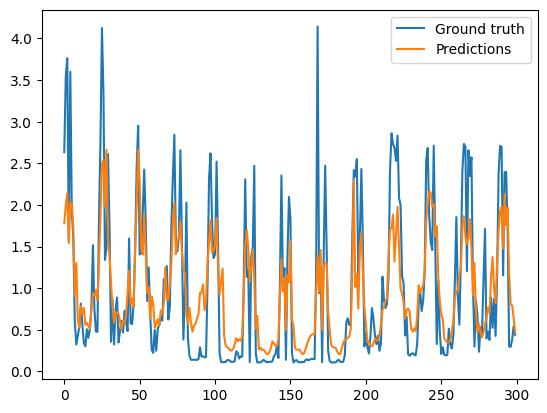

In [31]:
plt.plot(Y_test[:300, 0], label="Ground truth")
plt.plot(preds[:300, 0], label="Predictions")
plt.legend()

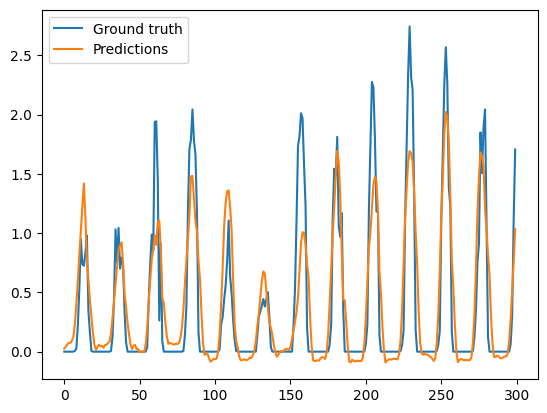

In [32]:
plt.plot(Y_test[:300, 1], label="Ground truth")
plt.plot(preds[:300, 1], label="Predictions")
plt.legend()

In [15]:
Y_test.mean(axis=0)
# Y_test.std(axis=0)

array([0.88931784, 0.17576061])

# Electricity Consumption Dataset

In [ ]:
with open("data/electricity_consumption_2020-2021.pkl", 'rb') as f:
    electricity_con_data = pickle.load(f)

with open("data/central_coast_hunter_weather.pkl", 'rb') as f:
    weather_data = pickle.load(f)

In [ ]:
def get_customer_data(lga=0, customer=0):
    idx = np.arange(30, len(electricity_con_data[lga][customer]))
    expanded_idx = np.array([np.arange(i - 30, i - 1) for i in idx])
    return np.concatenate((electricity_con_data[lga][customer, expanded_idx].reshape(-1, 29, 1), weather_data[str(lga)][expanded_idx]), axis=-1), electricity_con_data[lga][customer, idx]

In [ ]:
def create_model() -> tf.keras.Model:
    inputs = tf.keras.Input((29, 8))
    # x = tf.keras.layers.Flatten()(inputs)
    x = tf.keras.layers.Conv1D(64, 5, activation="relu")(inputs)
    x = tf.keras.layers.Conv1D(64, 3, activation="relu")(x)
    x = tf.keras.layers.Conv1D(32, 2, activation="relu")(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(100, activation="relu")(x)
    x = tf.keras.layers.Dense(50, activation="relu")(x)
    x = tf.keras.layers.Dense(1, activation="linear")(x)
    model = tf.keras.Model(inputs=inputs, outputs=x)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
        loss="mean_squared_error",
        metrics=["mean_absolute_error", tf.keras.metrics.RootMeanSquaredError()]
    )
    return model

In [ ]:
def create_clients(create_model_fn, nclients, seed=None):
    def create_client(client_id: str):
        lga = int(client_id[:client_id.find('-')])
        customer = int(client_id[client_id.find('-') + 1:])
        client_X, client_Y = get_customer_data(lga, customer)
        client_data = {"train": {"X": client_X[:300], "Y": client_Y[:300]}, "test": {"X": client_X[300:], "Y": client_Y[300:]}}
        return Client(client_data, create_model_fn)
    return create_client

In [ ]:
class Client(flagon.Client):
    def __init__(self, data, create_model_fn):
        self.data = data
        self.model = create_model_fn()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        history = self.model.fit(self.data['train']['X'], self.data['train']['Y'], epochs=config['num_epochs'])
        return self.model.get_weights(), len(self.data['train']), {k: v[-1] for k, v in history.history.items()}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        loss, mae, rmse = self.model.evaluate(self.data['test']['X'], self.data['test']['Y'])
        return len(self.data['test']), {'loss': loss, 'mean absolute error': mae, 'root mean squared error': rmse}

In [ ]:
server = flagon.Server(create_model().get_weights(), {"num_rounds": 1, "num_episodes": 1, "num_epochs": 1})
network_arch = {
    "clients": [{"clients": lga_data.shape[0] // 1000} for lga_data in electricity_con_data.values()],
}
flagon.start_simulation(
    server,
    create_clients(create_model, flagon.common.count_clients(network_arch)),
    network_arch
)

KeyError: 96

11/11 [==============================] - 0s 672us/step


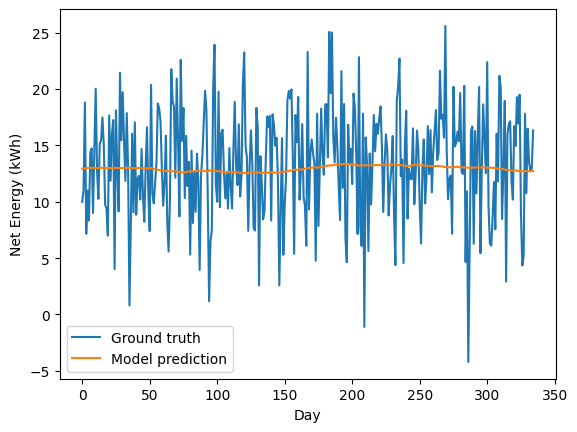

In [ ]:
plt.plot(np.arange(len(Y)), Y, '-', label="Ground truth")

preds = model.predict(X)
plt.plot(np.arange(len(preds)), preds, '-', label="Model prediction")
plt.xlabel("Day")
plt.ylabel("Net Energy (kWh)")
plt.legend()
plt.show()